###  GAN及其变体的原理
参考论文：   
基于生成对抗网络的模仿学习综述   计算机学报 2020,43(2) 作者：林嘉豪 章宗长   
生成式对抗网络及其计算机视觉应用研究综述 中国图像图形学报 2018，23(10),作者：曹仰杰 贾丽丽   
生成式对抗网络GAN 的研究进展与展望  自动化学报 2017,43(3),作者：王坤峰 苟超   
生成对抗网络研究综述  计算机系统应用  2019,28(11),作者：邹秀芳, 朱定局  
生成对抗网络GAN综述  计算机科学  2019,46(3),作者：程显毅  谢璐   

更详细请参考原始论文!!!

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

In [4]:
# Hyperparameters
random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 128
LATENT_DIM = 75
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x

In [5]:
IMG_SIZE

784

In [6]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

In [7]:
class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [8]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [9]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 
        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        

        ### FORWARD AND BACK PROP
        
        
        # --------------------------
        # Train Generator
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features)
        
        gener_loss = F.binary_cross_entropy(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)
        
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss)
        gener_costs.append(gener_loss)
        
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.6560/0.7171
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 4.8729/0.0358
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 1.8217/0.1074
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 1.1520/0.2394
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 2.6925/0.0709
Time elapsed: 0.21 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 1.6379/0.2411
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 2.6139/0.1243
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 1.8020/0.2481
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 1.0411/0.4529
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 0.9164/0.5492
Time elapsed: 0.49 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 0.8524/0.5206
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 1.0929/0.3967
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 1.3360/0.3270
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 1.4117/0.3808
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 1.4087/0.3233
Time elapsed: 0.75 min
Epoch: 004/100 |

Epoch: 050/100 | Batch 400/469 | Gen/Dis Loss: 1.0098/0.6360
Time elapsed: 15.34 min
Epoch: 051/100 | Batch 000/469 | Gen/Dis Loss: 0.7522/0.6603
Epoch: 051/100 | Batch 100/469 | Gen/Dis Loss: 1.0019/0.5886
Epoch: 051/100 | Batch 200/469 | Gen/Dis Loss: 0.7830/0.5913
Epoch: 051/100 | Batch 300/469 | Gen/Dis Loss: 0.9147/0.6269
Epoch: 051/100 | Batch 400/469 | Gen/Dis Loss: 0.9268/0.5933
Time elapsed: 15.75 min
Epoch: 052/100 | Batch 000/469 | Gen/Dis Loss: 0.9434/0.6481
Epoch: 052/100 | Batch 100/469 | Gen/Dis Loss: 0.8303/0.6495
Epoch: 052/100 | Batch 200/469 | Gen/Dis Loss: 1.4384/0.5985
Epoch: 052/100 | Batch 300/469 | Gen/Dis Loss: 0.8888/0.6460
Epoch: 052/100 | Batch 400/469 | Gen/Dis Loss: 0.9884/0.5966
Time elapsed: 16.10 min
Epoch: 053/100 | Batch 000/469 | Gen/Dis Loss: 0.9186/0.6283
Epoch: 053/100 | Batch 100/469 | Gen/Dis Loss: 0.8079/0.6011
Epoch: 053/100 | Batch 200/469 | Gen/Dis Loss: 1.0648/0.6028
Epoch: 053/100 | Batch 300/469 | Gen/Dis Loss: 1.1946/0.5826
Epoch: 053/10

Epoch: 100/100 | Batch 200/469 | Gen/Dis Loss: 0.8379/0.6768
Epoch: 100/100 | Batch 300/469 | Gen/Dis Loss: 0.9681/0.6653
Epoch: 100/100 | Batch 400/469 | Gen/Dis Loss: 0.9585/0.5865
Time elapsed: 39.52 min
Total Training Time: 39.52 min


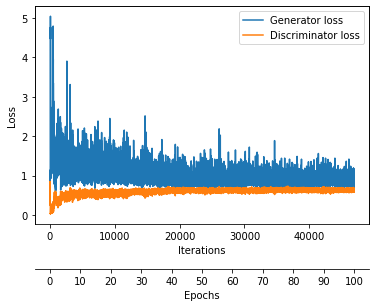

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.show()

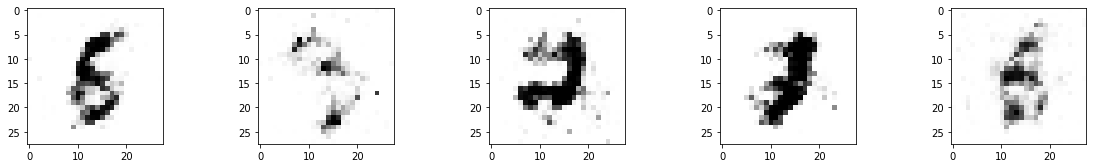

In [11]:
model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')